## import time
import numpy as np
import pandas as pd
import geocoder
pd.options.mode.chained_assignment = None
import missingno as mno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [1]:
import numpy as np
import pandas as pd
import missingno as mno

In [2]:
df = pd.read_csv('housing.com_geocoded.csv')
print(df.shape)
df.head(2)

(17999, 11)


,price,title,location,Avg. Price,Built Up Area,Possession Date,full_loc,gmaps_info,coord,lat,lng
0,1.18 Cr - 2.37 Cr,Alfa Mana A M Residency,"Mazgaon, Mumbai",NaN,NaN,"Sep, 2020","Alfa Mana A M Residency, Mazgaon, Mumbai",[{'address_components': [{'long_name': 'Shop N...,"(18.938788, 72.838105)",18.938788,72.838105
1,6.5 Cr - 6.8 Cr,Sanghvi Parsssva ExcellenSea,"Charni Road, Girgaon, Mumbai",NaN,NaN,"Dec, 2022","Sanghvi Parsssva ExcellenSea, Charni Road, Gir...",[{'address_components': [{'long_name': 'Bombay...,"(18.9304714, 72.8335331)",18.930471,72.833533


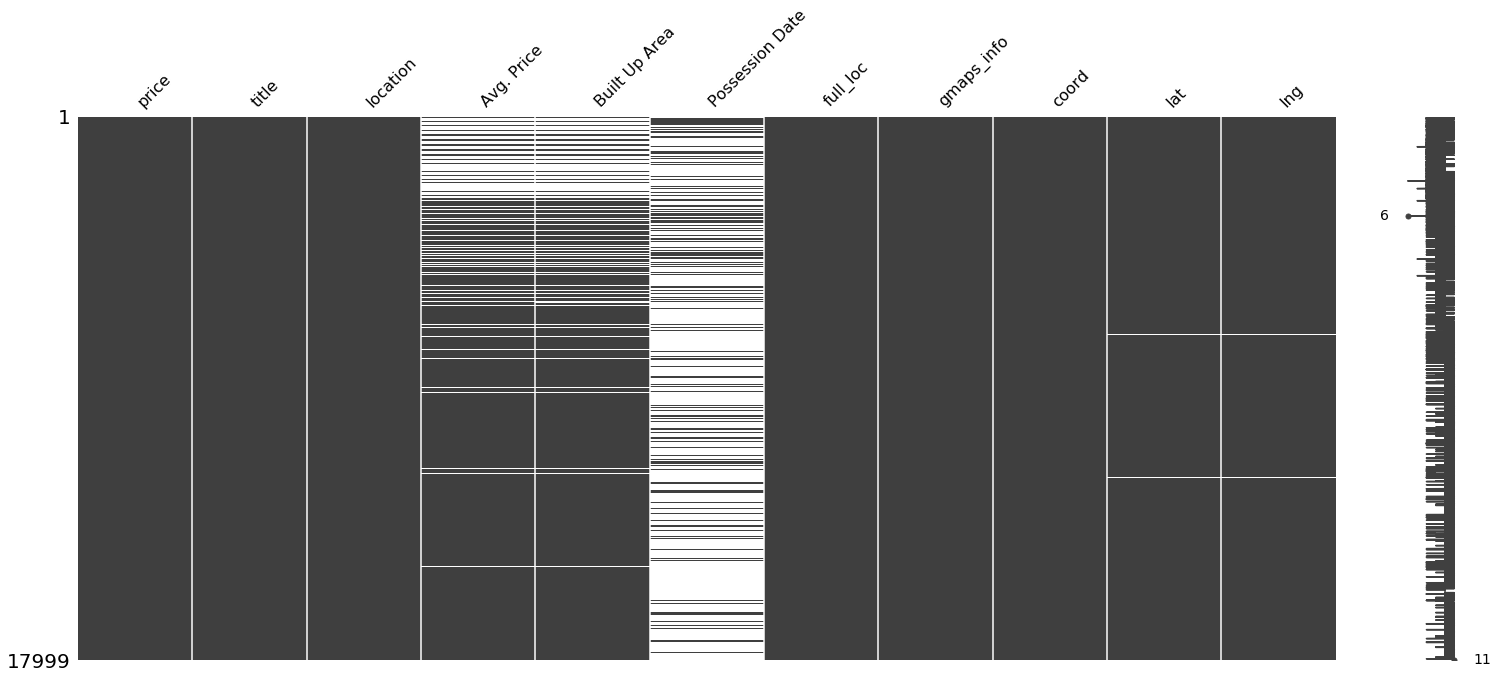

In [3]:
mno.matrix(df);

### drop columns

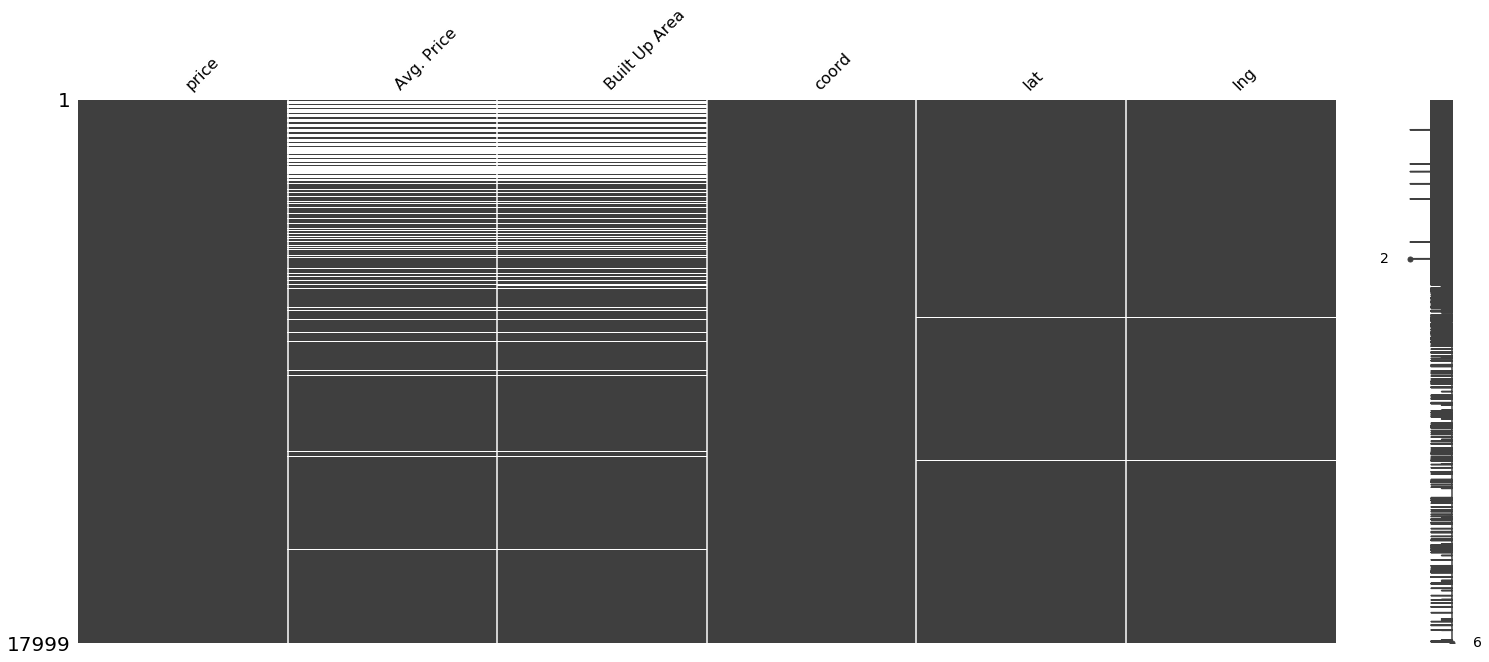

In [4]:
df = df.drop(columns=['title','location','full_loc',
                      'Possession Date', 'gmaps_info']
             +[c for c in df.columns if 'FOR' in c])
mno.matrix(df);

## cleaning

In [5]:
df[[c for c in df.columns if 'price' in c.lower()]].head()

,price,Avg. Price
0,1.18 Cr - 2.37 Cr,NaN
1,6.5 Cr - 6.8 Cr,NaN
2,3.36 Cr - 4.95 Cr,NaN
3,87.5 L,11.09k / sqft.
4,1.05 Cr - 2.53 Cr,NaN


### Clean/engineer price data

In [6]:
def get_lo_price(x):
    if len(x)!=1: return x[0]
    else: return np.nan
def get_hi_price(x):
    if len(x)!=1: return x[1]
    else: return np.nan
def get_one_price(x):
    if len(x)==1: return x[0]
    else: return np.nan
df['lo_price'] = df['price'].str.split('-').apply(get_lo_price)
df['hi_price'] = df['price'].str.split('-').apply(get_hi_price)
df['one_price'] = df['price'].str.split('-').apply(get_one_price)
df[[c for c in df.columns if 'price' in c.lower()]].head()

,price,Avg. Price,lo_price,hi_price,one_price
0,1.18 Cr - 2.37 Cr,NaN,1.18 Cr,2.37 Cr,NaN
1,6.5 Cr - 6.8 Cr,NaN,6.5 Cr,6.8 Cr,NaN
2,3.36 Cr - 4.95 Cr,NaN,3.36 Cr,4.95 Cr,NaN
3,87.5 L,11.09k / sqft.,NaN,NaN,87.5 L
4,1.05 Cr - 2.53 Cr,NaN,1.05 Cr,2.53 Cr,NaN


In [7]:
def parse_price(x):
    try:
        if 'l' in x.lower():
            return float(x.split()[0])*100000
        if 'c' in x.lower():
            return float(x.split()[0])*10000000
    except: pass
    
for c in df.columns:
    if '_price' in c:
        df[c] = df[c].apply(parse_price)
df.drop(columns='price', inplace=True)
df[[c for c in df.columns if 'price' in c.lower()]].head()

,Avg. Price,lo_price,hi_price,one_price
0,NaN,11800000.0,23700000.0,NaN
1,NaN,65000000.0,68000000.0,NaN
2,NaN,33600000.0,49500000.0,NaN
3,11.09k / sqft.,NaN,NaN,8750000.0
4,NaN,10500000.0,25300000.0,NaN


In [8]:
def parse_avg_price(x):
    try: return float(x.split('/')[0][:-2])*1000
    except: return np.nan
df['Avg. Price'] = df['Avg. Price'].apply(parse_avg_price)

In [9]:
def parse_bltup_area(x):
    try: return float(x.split()[0])
    except: return np.nan
df['Built Up Area'] = df['Built Up Area'].apply(parse_bltup_area)

In [11]:
df.rename(columns={'Avg. Price':'avg_price_sqft'}, inplace=True)
df.head()

,avg_price_sqft,Built Up Area,coord,lat,lng,lo_price,hi_price,one_price
0,NaN,NaN,"(18.938788, 72.838105)",18.938788,72.838105,11800000.0,23700000.0,NaN
1,NaN,NaN,"(18.9304714, 72.8335331)",18.930471,72.833533,65000000.0,68000000.0,NaN
2,NaN,NaN,"(18.9801254, 72.84028599999999)",18.980125,72.840286,33600000.0,49500000.0,NaN
3,11090.0,789.0,"(19.160481, 72.9454193)",19.160481,72.945419,NaN,NaN,8750000.0
4,NaN,NaN,"(19.1296654, 72.93163609999999)",19.129665,72.931636,10500000.0,25300000.0,NaN


### export

In [12]:
df.to_csv('housing.com_CLEANED.csv')

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

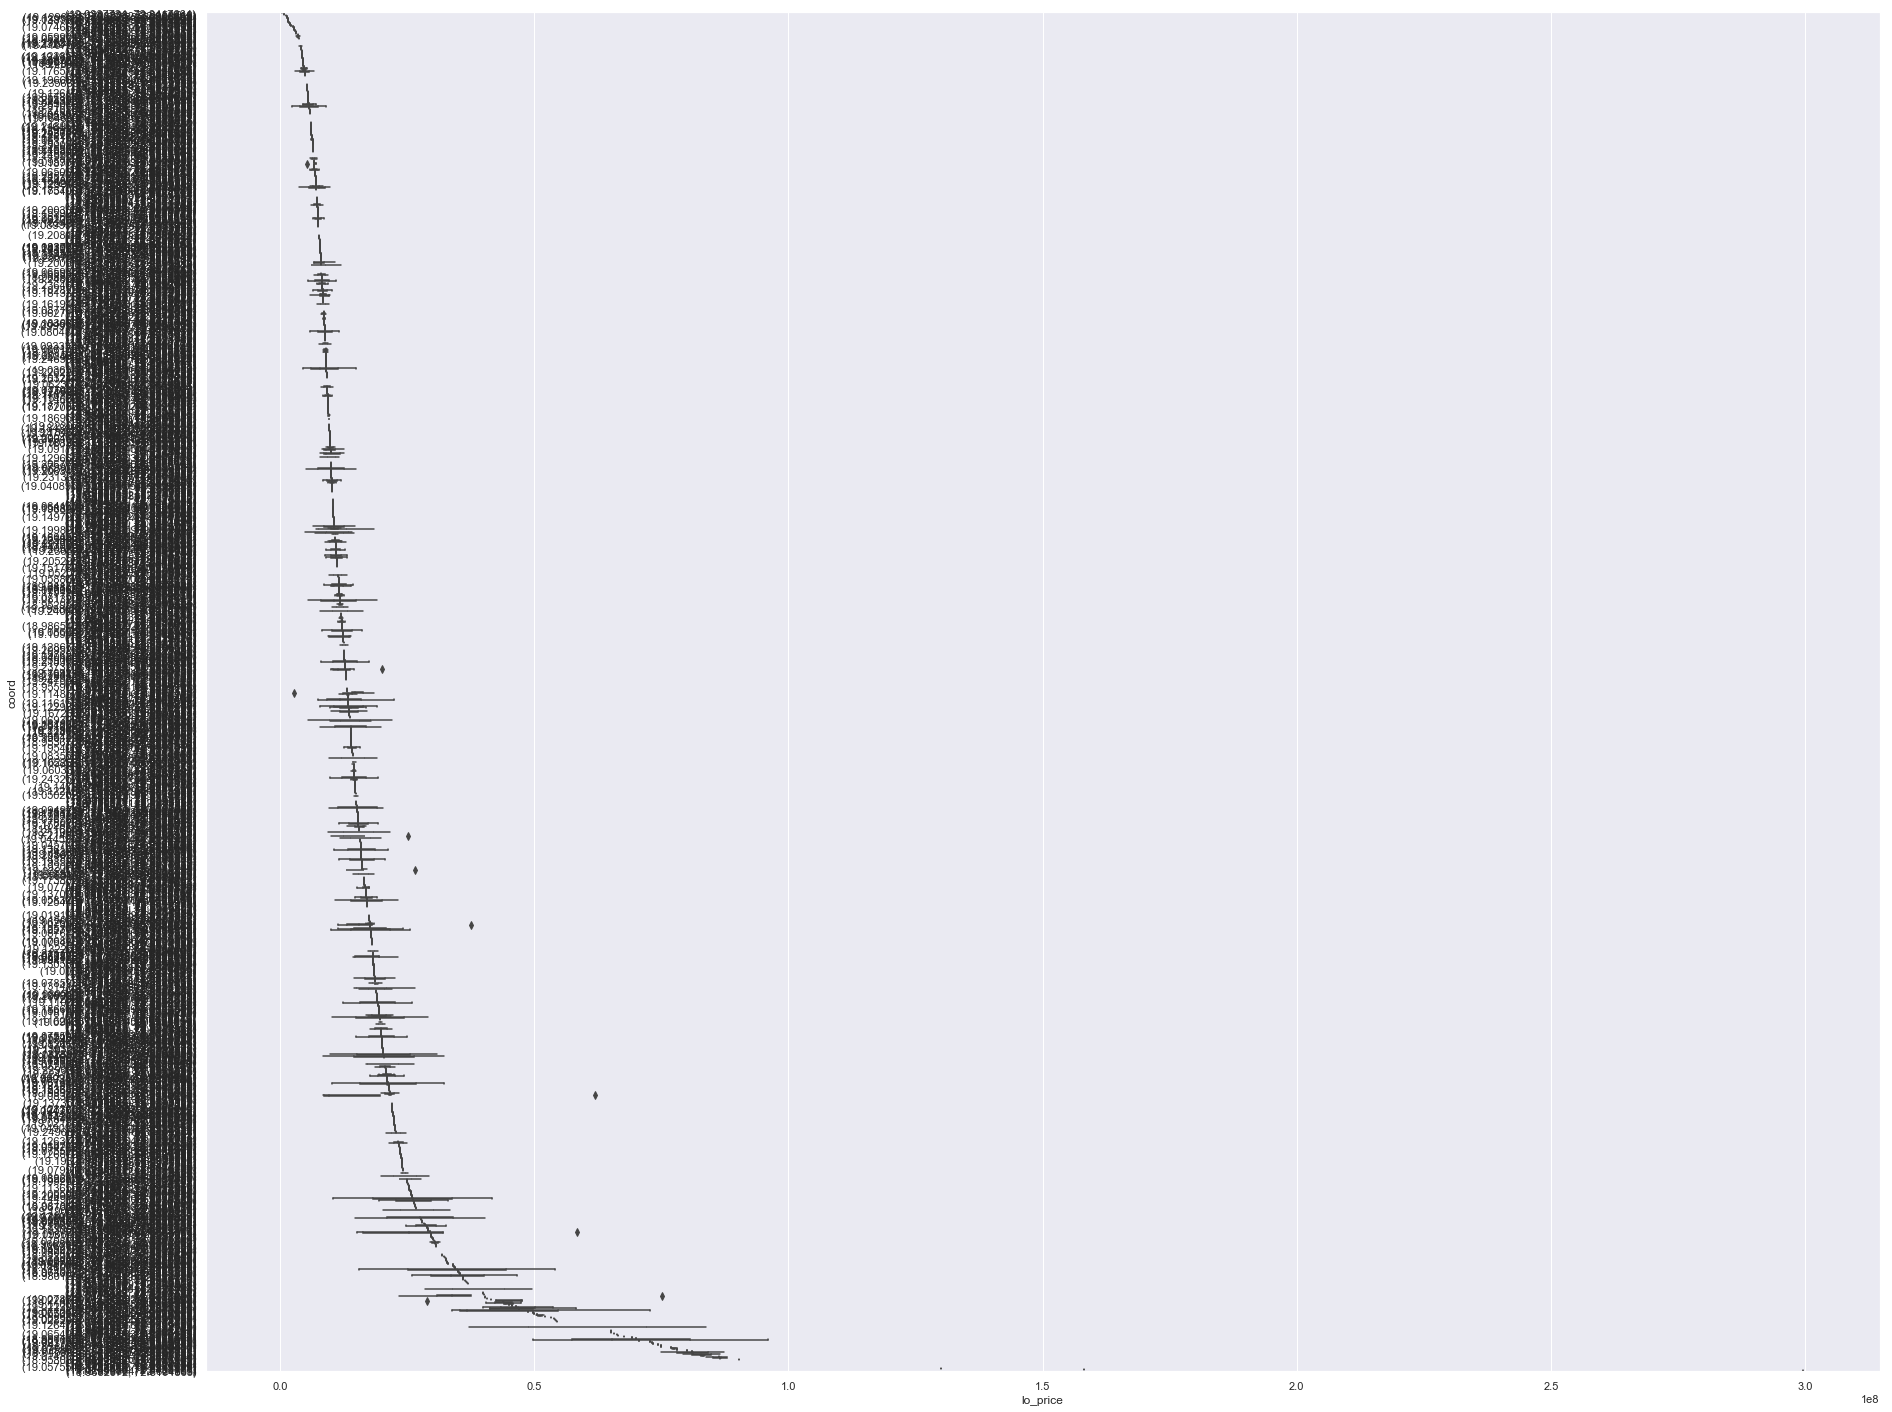

In [178]:
df_loprices = df[df['lo_price'].notna()]
locations_by_mean_loprice = df_loprices.groupby('coord').mean()['lo_price']
def location_loprice_sort(x):
    try:
        return locations_by_mean_loprice[x]
    except:
        return np.nan
df['location_loprice_index'] = df['coord'].apply(location_loprice_sort)
df_loprices=df[df['lo_price'].notna()]
plt.figure(figsize=(30,25))
sns.boxplot(y='coord', x='lo_price', data=df_loprices.sort_values('location_loprice_index'));